In [ ]:
!pip install mne hmmlearn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from hmmlearn import hmm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import os
import random
import math
import warnings
import time

warnings.filterwarnings('ignore')

from einops.layers.torch import Rearrange
from einops import rearrange

def set_seed(seed=3407):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(3407)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
# TRAIN
data_dir_train = "./npy-files/train"  
X_train = np.load(os.path.join(data_dir_train, "X_all.npy"))
y_train = np.load(os.path.join(data_dir_train, "y_all.npy"))
X_hmm_train = np.load(os.path.join(data_dir_train, "X_all_hmm.npy"))

print(f"TRAIN - X: {X_train.shape}, y: {y_train.shape}, HMM: {X_hmm_train.shape}")

# TEST  
data_dir_test = "./npy-files/test"     
X_test = np.load(os.path.join(data_dir_test, "X_all_test.npy"))
y_test = np.load(os.path.join(data_dir_test, "y_all_test.npy"))
X_hmm_test = np.load(os.path.join(data_dir_test, "X_all_hmm_test.npy"))

print(f"TEST  - X: {X_test.shape}, y: {y_test.shape}, HMM: {X_hmm_test.shape}")

X_train_aug = np.concatenate([X_train, X_hmm_train], axis=1)
X_test_aug  = np.concatenate([X_test,  X_hmm_test],  axis=1)

print(f"\nAugmented TRAIN: {X_train_aug.shape}")
print(f"Augmented TEST:  {X_test_aug.shape}")

TRAIN - X: (3240, 9009), y: (3240,), HMM: (3240, 3)
TEST  - X: (810, 9009), y: (810,), HMM: (810, 3)

Augmented TRAIN: (3240, 9012)
Augmented TEST:  (810, 9012)


In [4]:
class EEG_MLP_Deep(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.ln1 = nn.LayerNorm(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.ln2 = nn.LayerNorm(256)
        self.fc3 = nn.Linear(256, 128)
        self.ln3 = nn.LayerNorm(128)
        self.fc4 = nn.Linear(128, 64)
        self.ln4 = nn.LayerNorm(64)
        self.res_fc = nn.Linear(input_dim, 64)
        self.out = nn.Linear(64, 2)
        self.drop = nn.Dropout(0.5)
    
    def forward(self, x):
        x1 = F.gelu(self.ln1(self.bn1(self.fc1(x))))
        x2 = F.gelu(self.ln2(self.bn2(self.fc2(x1))))
        x3 = F.gelu(self.ln3(self.fc3(x2)))
        x4 = self.drop(F.gelu(self.ln4(self.fc4(x3))))
        res = 0.3 * F.gelu(self.res_fc(x))
        return self.out(x4 + res)

In [5]:
class EEG_GRU_Attn(nn.Module):
    def __init__(self, input_dim, nhead=8):
        super().__init__()
        self.gru = nn.GRU(input_dim, 256, num_layers=3, batch_first=True,
                          dropout=0.3, bidirectional=True)
        self.pos_enc = nn.Parameter(torch.randn(1, 10, 512))
        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=nhead,
                                                    dim_feedforward=1024, dropout=0.3, batch_first=True)
        self.attn_net = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512, 128), nn.GELU(), nn.Dropout(0.4),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 10, 1)
        out, _ = self.gru(x)
        out = out + self.pos_enc
        attended = self.attn_net(out)
        context = attended.mean(1)
        return self.fc(context)

In [6]:
class EEG_BiLSTM_Res(nn.Module):
    def __init__(self, input_dim, nhead=8):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 128, num_layers=3, batch_first=True,
                            bidirectional=True, dropout=0.3)
        self.pos_enc = nn.Parameter(torch.randn(1, 10, 256))
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=nhead,
                                                    dim_feedforward=512, dropout=0.3, batch_first=True)
        self.attn_net = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.res_fc = nn.Linear(input_dim, 256)
        self.fc = nn.Sequential(
            nn.LayerNorm(256),
            nn.Linear(256, 128), nn.GELU(), nn.Dropout(0.4),
            nn.Linear(128, 64), nn.GELU(),
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        x_seq = x.unsqueeze(1).repeat(1, 10, 1)
        out, _ = self.lstm(x_seq)
        out = out + self.pos_enc
        attended = self.attn_net(out)
        context = attended.mean(1)
        res = 0.3 * F.gelu(self.res_fc(x))
        return self.fc(context + res)

In [7]:
class EEG_Transformer_Deep(nn.Module):
    def __init__(self, input_dim, nhead=16):
        super().__init__()
        self.embed = nn.Linear(input_dim, 256)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=256, nhead=nhead, dim_feedforward=1024,
            dropout=0.3, activation='gelu', batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=6)
        self.norm = nn.LayerNorm(256)
        self.fc = nn.Sequential(
            nn.Linear(256, 128), nn.GELU(), nn.Dropout(0.4),
            nn.Linear(128, 64), nn.GELU(),
            nn.Linear(64, 2)
        )
        self.pos_enc = self._generate_pos_enc(10, 256)
    
    def _generate_pos_enc(self, seq_len, d_model):
        pe = torch.zeros(1, seq_len, d_model)
        position = torch.arange(0, seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                             -(math.log(torch.tensor(10000.0)) / d_model))
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        return nn.Parameter(pe)
    
    def forward(self, x):
        x_seq = x.unsqueeze(1).repeat(1, 10, 1)
        x_embed = self.embed(x_seq) + self.pos_enc
        encoded = self.encoder(x_embed)
        context = self.norm(encoded.mean(1))
        return self.fc(context)

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40, patch_len=15):
        super().__init__()
        self.shallow = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), stride=1),
            nn.Conv2d(40, 40, (9, 1), stride=1),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Dropout(0.5),
        )
        self.time_pool = nn.AdaptiveAvgPool2d((1, patch_len))
        self.proj = nn.Sequential(
            nn.Conv2d(40, emb_size, kernel_size=1),
            Rearrange('b e h w -> b (h w) e')
        )
    
    def forward(self, x):
        x = self.shallow(x)
        x = self.time_pool(x)
        return self.proj(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads=10, dropout=0.5):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.proj = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
    
    def forward(self, x):
        Q = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        K = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        V = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum("bhqd, bhkd -> bhqk", Q, K)
        att = F.softmax(energy / (self.emb_size ** 0.5), dim=-1)
        att = self.att_drop(att)
        out = torch.einsum("bhqk, bhkd -> bhqd", att, V)
        out = rearrange(out, "b h n d -> b n (h d)")
        return self.proj(out)

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion=4, dropout=0.5):
        super().__init__(
            nn.Linear(emb_size, emb_size * expansion),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(emb_size * expansion, emb_size)
        )

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=40, num_heads=10, dropout=0.5):
        super().__init__()
        self.att = nn.Sequential(
            nn.LayerNorm(emb_size),
            MultiHeadAttention(emb_size, num_heads, dropout),
            nn.Dropout(dropout)
        )
        self.ff = nn.Sequential(
            nn.LayerNorm(emb_size),
            FeedForwardBlock(emb_size, dropout=dropout),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        x = x + self.att(x)
        x = x + self.ff(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, depth, emb_size):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(emb_size) for _ in range(depth)
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class EEG_Conformer_Deep(nn.Module):
    def __init__(self, input_dim, n_classes=2, emb_size=40, depth=6):
        super().__init__()
        self.T = max(input_dim // 9, 40)
        self.reshape = nn.Sequential(
            nn.Linear(input_dim, 9 * self.T),
            nn.GELU()
        )
        self.patch_embed = PatchEmbedding(emb_size)
        self.encoder = TransformerEncoder(depth, emb_size)
        self.cls_head = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, 128), nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64), nn.GELU(),
            nn.Linear(64, n_classes)
        )
    
    def forward(self, x):
        B = x.size(0)
        x = self.reshape(x)
        x = x.view(B, 1, 9, self.T)
        patches = self.patch_embed(x)
        encoded = self.encoder(patches)
        context = encoded.mean(dim=1)
        return self.cls_head(context)

In [9]:
class EEGNet_Std(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.drop2 = nn.Dropout(0.4)
        self.out = nn.Linear(128, 2)
    
    def forward(self, x):
        x = F.elu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = F.elu(self.bn2(self.fc2(x)))
        x = F.elu(self.fc3(x))
        x = self.drop2(x)
        return self.out(x)

In [10]:
class EEGNet_SSVEP_Std(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 128)
        self.drop2 = nn.Dropout(0.5)
        self.out = nn.Linear(128, 2)
    
    def forward(self, x):
        x = F.elu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = F.elu(self.bn2(self.fc2(x)))
        x = self.drop2(F.elu(self.fc3(x)))
        return self.out(x)

In [11]:
class DeepConvNet_Std(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.drop1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(64, 128, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)
        
        with torch.no_grad():
            sample = torch.zeros(1, 1, input_dim)
            sample = self.pool1(F.elu(self.bn1(self.conv1(sample))))
            sample = self.pool2(F.elu(self.bn2(self.conv2(sample))))
            sample = self.pool3(F.elu(self.bn3(self.conv3(sample))))
            flat_dim = sample.numel()
        
        self.fc1 = nn.Linear(flat_dim, 128)
        self.drop2 = nn.Dropout(0.4)
        self.out = nn.Linear(128, 2)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.drop1(self.pool1(F.elu(self.bn1(self.conv1(x)))))
        x = self.pool2(F.elu(self.bn2(self.conv2(x))))
        x = self.pool3(F.elu(self.bn3(self.conv3(x))))
        x = x.flatten(1)
        x = self.drop2(F.elu(self.fc1(x)))
        return self.out(x)

In [12]:
class ShallowConvNet_Std(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv = nn.Conv1d(1, 40, 9, padding=6)
        self.pool = nn.AvgPool1d(35, stride=7)
        self.drop = nn.Dropout(0.5)
        
        final_len = (input_dim + 6*2 - 9 + 1)
        final_len = (final_len - 35) // 7 + 1
        
        self.fc = nn.Linear(40 * final_len, 2)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x ** 2
        x = self.pool(x)
        x = torch.log(torch.clip(x, 1e-7, 1e4))
        x = self.drop(x)
        x = x.flatten(1)
        return self.fc(x)

In [13]:
class GraphConvLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_nodes, dropout=0.3):
        super().__init__()
        self.num_nodes = num_nodes
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.bn = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(dropout)
        self.residual = (in_dim == out_dim)
    
    def forward(self, x, A_hat):
        B, N, F_in = x.shape
        h = torch.matmul(A_hat, x)
        h = self.fc(h)
        h = h.view(B * N, -1)
        h = self.bn(h)
        h = h.view(B, N, -1)
        h = F.gelu(h)
        h = self.dropout(h)
        if self.residual:
            h = h + x
        return h

class EEG_GNN_Deep(nn.Module):
    def __init__(self, input_dim, n_classes=2, num_nodes=9,
                 temporal_hidden=64, gnn_hidden=128,
                 num_gnn_layers=3, min_T=40):
        super().__init__()
        self.num_nodes = num_nodes
        self.T = max(input_dim // num_nodes, min_T)
        self.reshape_fc = nn.Linear(input_dim, num_nodes * self.T)
        self.temp_fc = nn.Linear(self.T, temporal_hidden)
        self.temp_bn = nn.BatchNorm1d(temporal_hidden)
        self.temp_drop = nn.Dropout(0.3)
        self.A_raw = nn.Parameter(torch.randn(num_nodes, num_nodes))
        
        gnn_layers = []
        in_dim = temporal_hidden
        for i in range(num_gnn_layers):
            out_dim = gnn_hidden
            gnn_layers.append(GraphConvLayer(in_dim, out_dim, num_nodes, dropout=0.3))
            in_dim = out_dim
        
        self.gnn_layers = nn.ModuleList(gnn_layers)
        self.readout_norm = nn.LayerNorm(gnn_hidden * 2)
        self.cls = nn.Sequential(
            nn.Linear(gnn_hidden * 2, 128),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, n_classes),
        )
    
    def _normalized_adj(self, device):
        A = F.relu(self.A_raw)
        I = torch.eye(self.num_nodes, device=device)
        A = A + I
        D = torch.sum(A, dim=-1, keepdim=True)
        A_hat = A / (D + 1e-6)
        return A_hat
    
    def forward(self, x):
        B = x.size(0)
        device = x.device
        x = self.reshape_fc(x)
        x = x.view(B, self.num_nodes, self.T)
        x = x.view(B * self.num_nodes, self.T)
        x = self.temp_fc(x)
        x = self.temp_bn(x)
        x = F.gelu(x)
        x = self.temp_drop(x)
        x = x.view(B, self.num_nodes, -1)
        
        A_hat = self._normalized_adj(device)
        h = x
        for gnn in self.gnn_layers:
            h = gnn(h, A_hat)
        
        h_mean = h.mean(dim=1)
        h_max, _ = h.max(dim=1)
        h_graph = torch.cat([h_mean, h_max], dim=-1)
        h_graph = self.readout_norm(h_graph)
        out = self.cls(h_graph)
        return out

In [14]:
def train_dl(model, train_loader, test_loader, epochs=200, lr=3e-4):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20, T_mult=2)
    loss_fn = nn.CrossEntropyLoss()
    best_acc, best_state = 0, None
    
    history_acc = []
    
    for epoch in range(epochs):
        model.train()
        losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        
        scheduler.step()
        
        model.eval()
        y_true, y_pred, y_prob = [], [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                out = model(xb)
                prob = torch.softmax(out, 1)[:, 1].cpu().numpy()
                pred = out.argmax(1).cpu().numpy()
                y_true.extend(yb.numpy())
                y_pred.extend(pred)
                y_prob.extend(prob)
        
        acc = accuracy_score(y_true, y_pred)
        history_acc.append(acc)
        f1 = f1_score(y_true, y_pred)
        try:
            auc = roc_auc_score(y_true, y_prob)
        except:
            auc = 0.0
        
        if acc > best_acc:
            best_acc, best_state = acc, model.state_dict()
        
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:03d}/{epochs} | Loss {np.mean(losses):.4f} | Acc {acc:.4f} | F1 {f1:.4f} | AUC {auc:.4f}")
    
    if best_state:
        model.load_state_dict(best_state)
    
    return best_acc, f1, auc, history_acc


DL with HMM features

Training GNN:
Epoch 001/100 | Loss 0.6785 | Acc 0.5753 | F1 0.2712 | AUC 0.8207
Epoch 050/100 | Loss 0.1823 | Acc 0.8617 | F1 0.8614 | AUC 0.9339
Epoch 100/100 | Loss 0.0444 | Acc 0.8580 | F1 0.8564 | AUC 0.9264

Training Conformer:
Epoch 001/100 | Loss 0.6878 | Acc 0.7099 | F1 0.6390 | AUC 0.7914
Epoch 050/100 | Loss 0.2577 | Acc 0.8457 | F1 0.8443 | AUC 0.8867
Epoch 100/100 | Loss 0.1183 | Acc 0.8395 | F1 0.8371 | AUC 0.8614

Training MLP:
Epoch 001/100 | Loss 0.7089 | Acc 0.6753 | F1 0.7419 | AUC 0.7938
Epoch 050/100 | Loss 0.1398 | Acc 0.8407 | F1 0.8409 | AUC 0.9156
Epoch 100/100 | Loss 0.0554 | Acc 0.8432 | F1 0.8442 | AUC 0.9256

Training GRU_Attn:
Epoch 001/100 | Loss 0.6838 | Acc 0.6815 | F1 0.7152 | AUC 0.7716
Epoch 050/100 | Loss 0.0166 | Acc 0.7975 | F1 0.8010 | AUC 0.8783
Epoch 100/100 | Loss 0.0044 | Acc 0.8025 | F1 0.8049 | AUC 0.8777

Training BiLSTM_Res:
Epoch 001/100 | Loss 0.6868 | Acc 0.6469 | F1 0.7174 | AUC 0.7688
Epoch 050/100 | Loss 0.2178

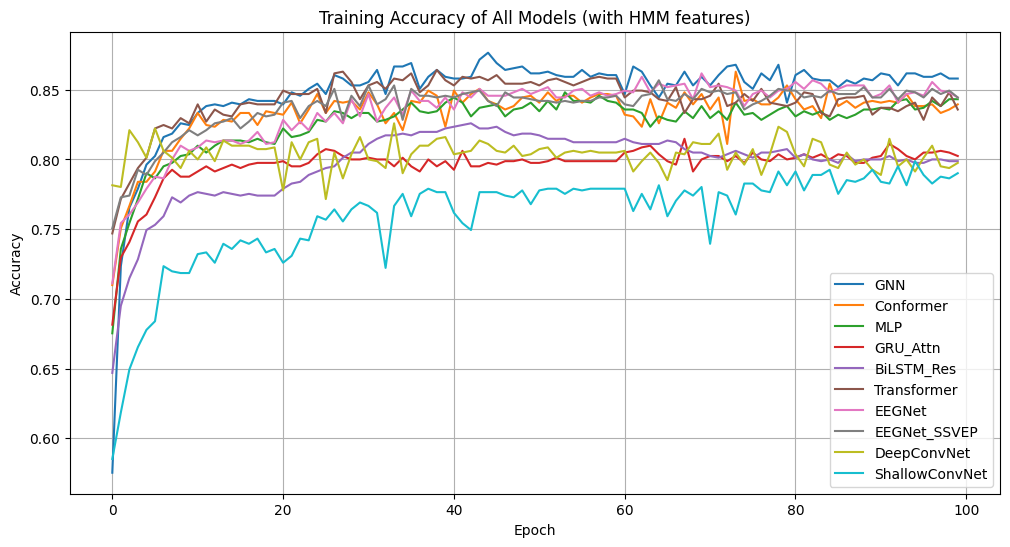

In [ ]:
def evaluate_dl(X_train, X_test, y_train, y_test, label):
    set_seed(3407)
    
    # Normalize
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    
    # To tensor
    X_train_t = torch.tensor(X_train_norm, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_test_t = torch.tensor(X_test_norm, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.long)
    
    # DataLoaders
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=128, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=256, shuffle=False)
    
    input_dim = X_train_norm.shape[1]
    
    # Models dictionary
    models = {
        "GNN": EEG_GNN_Deep(input_dim, num_nodes=22),
        "Conformer": EEG_Conformer_Deep(input_dim),
        "MLP": EEG_MLP_Deep(input_dim),
        "GRU_Attn": EEG_GRU_Attn(input_dim),
        "BiLSTM_Res": EEG_BiLSTM_Res(input_dim),
        "Transformer": EEG_Transformer_Deep(input_dim),
        "EEGNet": EEGNet_Std(input_dim),
        "EEGNet_SSVEP": EEGNet_SSVEP_Std(input_dim),
        "DeepConvNet": DeepConvNet_Std(input_dim),
        "ShallowConvNet": ShallowConvNet_Std(input_dim)
    }
    
    results = []
    histories_acc = {}
    print(f"\n{'='*60}")
    print(f"{label}")
    print(f"{'='*60}")
    
    for name, net in models.items():
        set_seed(3407)
        print(f"\nTraining {name}:")
        acc, f1, auc, history_acc = train_dl(net, train_loader, test_loader, epochs=100, lr=6e-6)
        histories_acc[name] = history_acc
        
        # Inference time
        net.eval()
        n_runs = 200
        xb_sample = next(iter(test_loader))[0][:1].to(device)
        
        with torch.no_grad():
            for _ in range(30):
                _ = net(xb_sample)
        
        if str(device).startswith("cuda"):
            torch.cuda.synchronize()
        
        start_inf = time.time()
        with torch.no_grad():
            for _ in range(n_runs):
                _ = net(xb_sample)
        
        if str(device).startswith("cuda"):
            torch.cuda.synchronize()
        
        inference_time_ms = (time.time() - start_inf) / n_runs * 1000
        
        results.append({
            "Model": name,
            "Accuracy": acc,
            "F1": f1,
            "AUC": auc,
            "InferTime_ms": inference_time_ms
        })
    
    df = pd.DataFrame(results).sort_values("Accuracy", ascending=False).reset_index(drop=True)
    print(f"\n{'='*60}")
    print(df.to_string(index=False))
    print(f"{'='*60}")

    plt.figure(figsize=(12,6))
    for name, acc_list in histories_acc.items():
        plt.plot(acc_list, label=name)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy of All Models (with HMM features)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df

df_dl_hmm = evaluate_dl(X_train_aug, X_test_aug, y_train, y_test, 
                                          "DL with HMM features")

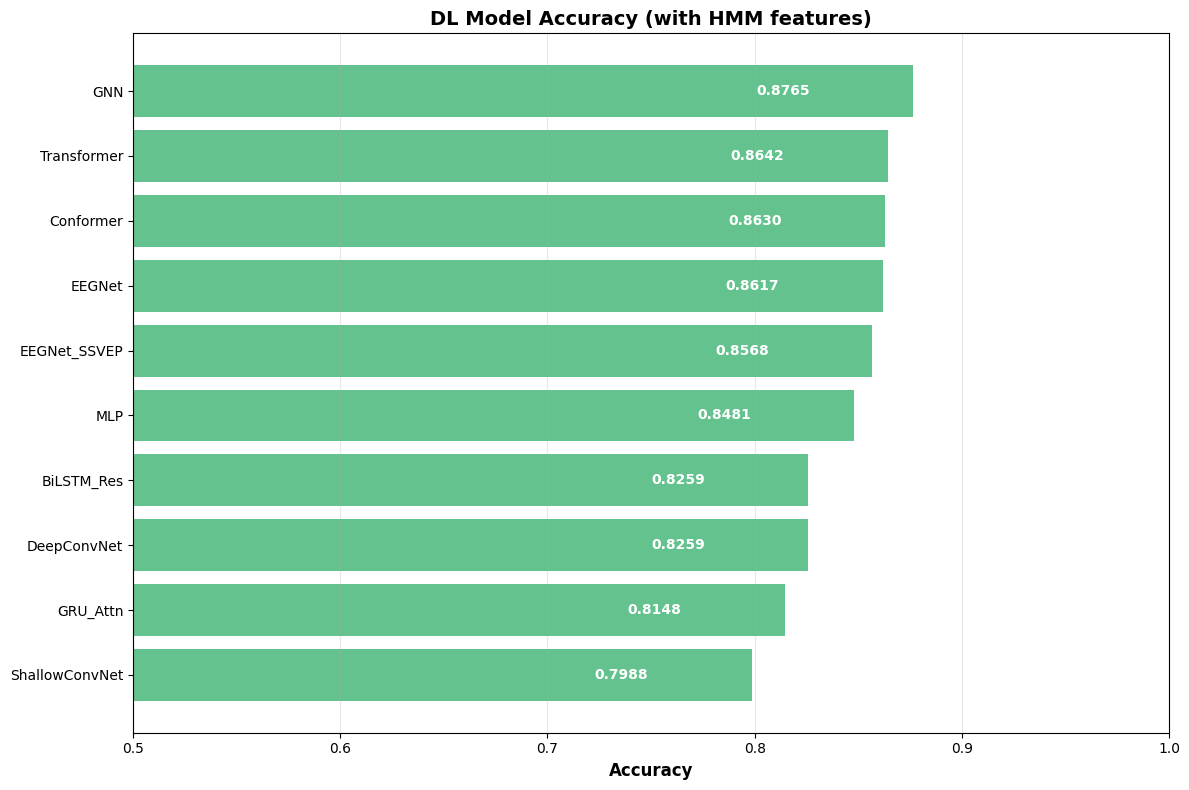

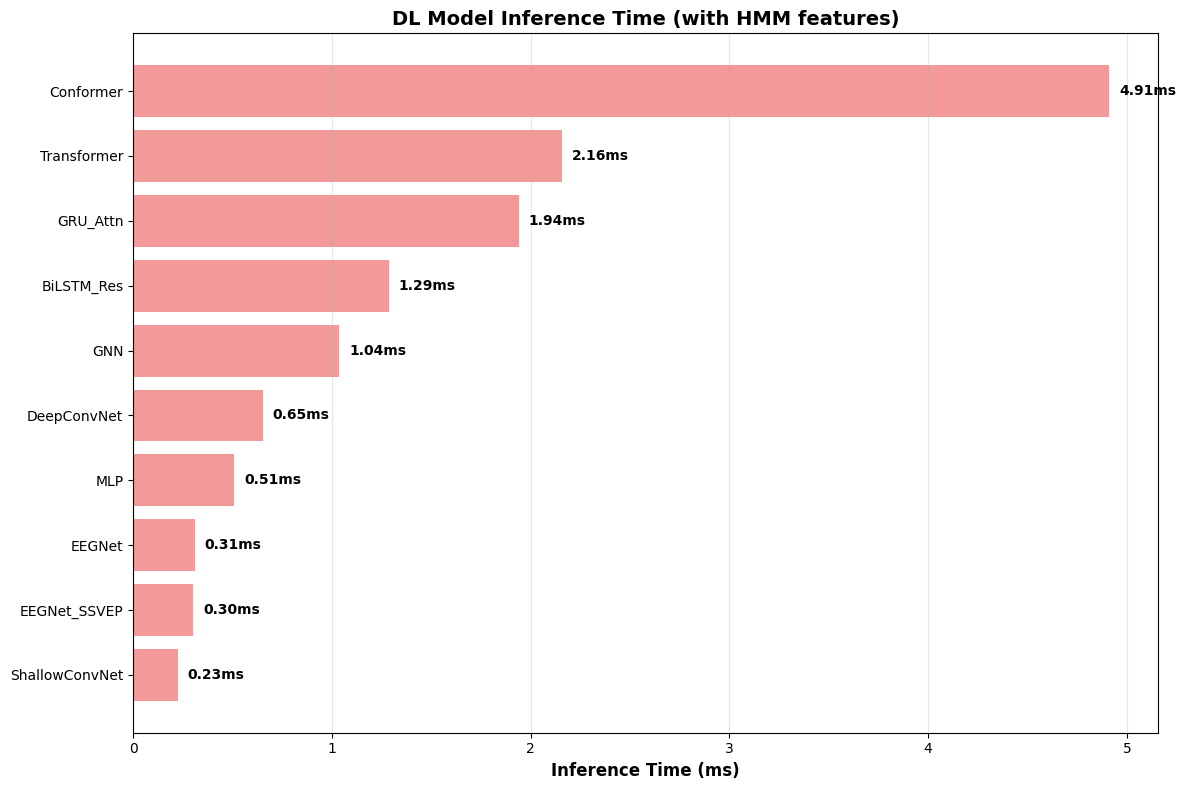

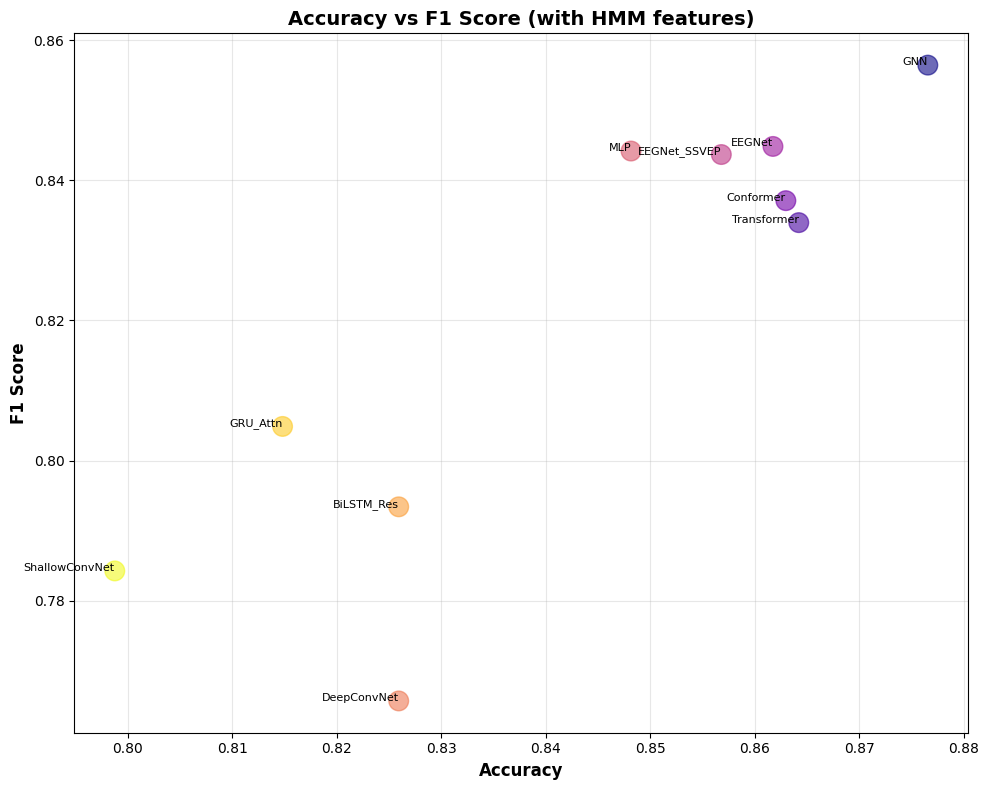

In [ ]:
def plot_accuracy_comparison_hmm(df_hmm):
    df_sorted = df_hmm.sort_values("Accuracy", ascending=True)
    models = df_sorted["Model"].values
    acc = df_sorted["Accuracy"].values
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(models, acc, color="mediumseagreen", alpha=0.8)
    for i, v in enumerate(acc):
        plt.text(v - 0.05, i, f"{v:.4f}", ha="right", va="center", fontweight="bold", color="white")
    
    plt.xlabel("Accuracy", fontsize=12, fontweight="bold")
    plt.title("DL Model Accuracy (with HMM features)", fontsize=14, fontweight="bold")
    plt.xlim(0.5, 1.0)
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.savefig("dl_hmm_accuracy.png", dpi=150)
    plt.show()

def plot_inference_time_hmm(df_hmm):
    df_sorted = df_hmm.sort_values("InferTime_ms", ascending=True)
    models = df_sorted["Model"].values
    times = df_sorted["InferTime_ms"].values
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(models, times, color="lightcoral", alpha=0.8)
    for i, v in enumerate(times):
        plt.text(v + 0.05, i, f"{v:.2f}ms", ha="left", va="center", fontweight="bold")
    
    plt.xlabel("Inference Time (ms)", fontsize=12, fontweight="bold")
    plt.title("DL Model Inference Time (with HMM features)", fontsize=14, fontweight="bold")
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.savefig("dl_hmm_inference_time.png", dpi=150)
    plt.show()

def plot_f1_vs_acc_hmm(df_hmm):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df_hmm["Accuracy"], df_hmm["F1"], s=200, alpha=0.6, 
                         c=range(len(df_hmm)), cmap="plasma")
    for i, txt in enumerate(df_hmm["Model"]):
        plt.annotate(txt, (df_hmm["Accuracy"].iloc[i], df_hmm["F1"].iloc[i]),
                    fontsize=8, ha="right")
    
    plt.xlabel("Accuracy", fontsize=12, fontweight="bold")
    plt.ylabel("F1 Score", fontsize=12, fontweight="bold")
    plt.title("Accuracy vs F1 Score (with HMM features)", fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("dl_hmm_f1_vs_acc.png", dpi=150)
    plt.show()

plot_accuracy_comparison_hmm(df_dl_hmm)
plot_inference_time_hmm(df_dl_hmm)
plot_f1_vs_acc_hmm(df_dl_hmm)